# Libraries

In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2 as cv

In [2]:
subfolder_path = Path.cwd()
notebooks_path = subfolder_path.parent
repo_path = notebooks_path.parent
os.chdir(str(subfolder_path))
#print current working directory
print(f'Current folder is: {os.getcwd()}\n')
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent.parent)) if sys.path[0] != str(thispath.parent.parent) else None

#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils

Current folder is: /home/ricardino/Documents/MAIA/tercer_semestre/Extra_activities/INCan/Added_value_feature_uncertainty/notebooks/budget



# IMP

## Visualize

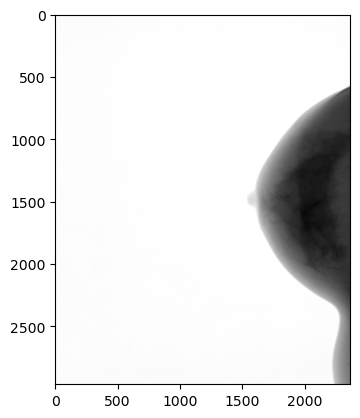

In [3]:
info = path_label() #create object with all patients info
pat = patient(info, num=0) #use only patient num 0
im = pat.im_sitk('CMC', 't1') #get sitk image of CMC t1
im = sitk.GetArrayFromImage(im) #transform to numpy array
plt.imshow(im, cmap='gray') #show

In [4]:
pat.im_path('CMC', 't1')

['data/images/pre-SET/Pat_02_RCC_CMC_t1.tif']

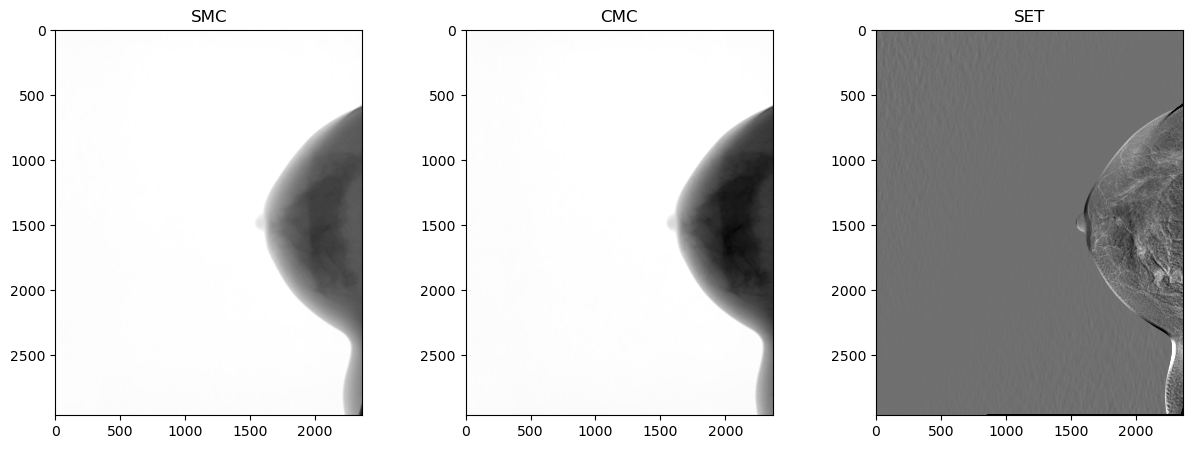

In [5]:
info = path_label()
i = 0
pat = patient(info, i)
# visualize image with SMC, image at time 1 and SET.
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title('SMC')
axs[0].imshow(pat.im_array(sequence='SMC'), cmap='gray')
axs[1].set_title('CMC')
axs[1].imshow(pat.im_array(sequence='CMC'), cmap='gray')
axs[2].set_title('SET')
axs[2].imshow(np.fliplr(pat.im_array(sequence='SET')), vmin = 32671, vmax =32893, cmap='gray')

### Check histograms

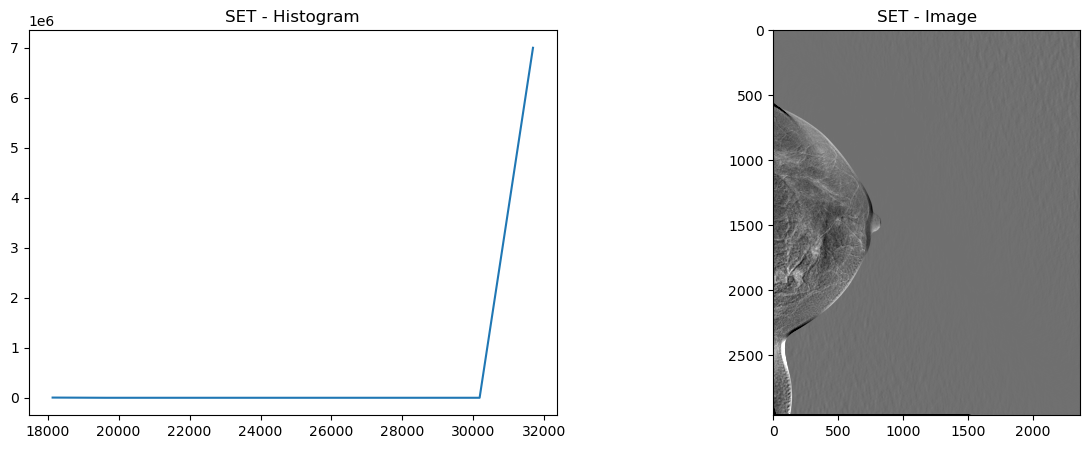

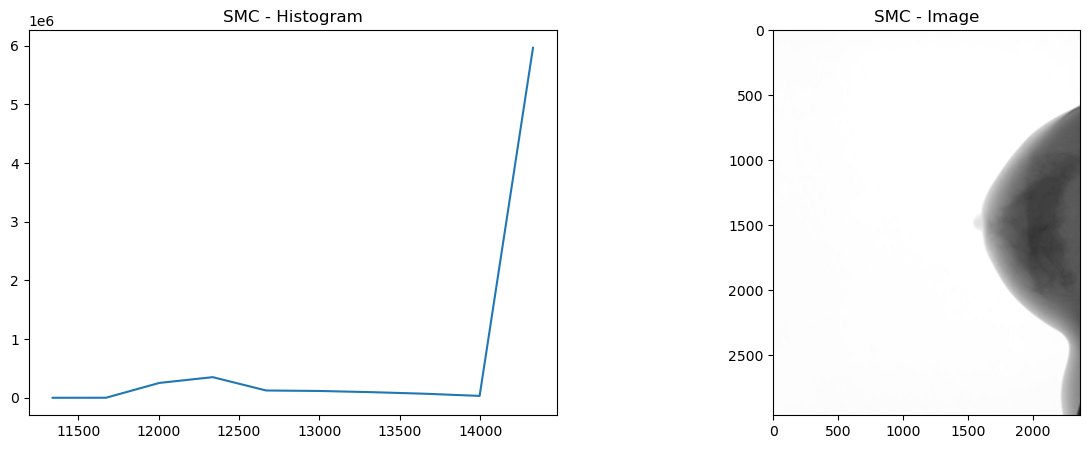

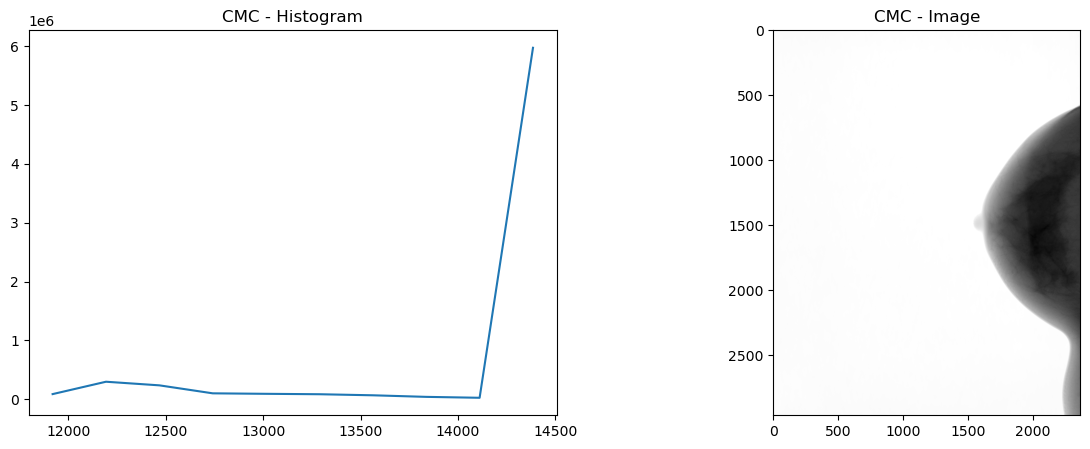

In [6]:
# We check the histograms of each image sequence
for seq in ['SET','SMC', 'CMC']:
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].set_title(f'{seq} - Histogram')
    hist = np.histogram(pat.im_array(sequence=seq))
    axs[0].plot(hist[1][:-1], hist[0])
    axs[1].set_title(f'{seq} - Image')
    axs[1].imshow(pat.im_array(sequence=seq), cmap='gray') if seq != 'SET' else axs[1].imshow(pat.im_array(sequence=seq), vmin = 32671, vmax =32893, cmap='gray')

## Image substraction

Images precontrast (SMC) and post contrast (CMC) are supposed ot be registered.
To check that, we substract them and check that they output the same result as the SET t1 images

First, we check some information about each image.

In [7]:
info = path_label() #create object with all patients info
pat = patient(info, num=1) #use only patient 0

print(f'Patient number: {pat.pat_num}')

#Print dtype of images and min max values
print(f'The dtype of the images is\n CMC: {pat.im_array(sequence="CMC").dtype}\n SMC: {pat.im_array(sequence="SMC").dtype}\n SET: {pat.im_array(sequence="SET").dtype}')
print(f'The min and max values of the images are\n CMC: {pat.im_array(sequence="CMC").min(), pat.im_array(sequence="CMC").max()}\n SMC: {pat.im_array(sequence="SMC").min(), pat.im_array(sequence="SMC").max()}\n SET: {pat.im_array(sequence="SET").min(), pat.im_array(sequence="SET").max()}')
print(f'The size of the image are\n CMC: {pat.im_array(sequence="CMC").shape}\n SMC: {pat.im_array(sequence="SMC").shape}\n SET: {pat.im_array(sequence="SET").shape}')
print(f'The ranges of the images are\n CMC: {pat.im_array(sequence="CMC").ptp()}\n SMC: {pat.im_array(sequence="SMC").ptp()}\n SET: {pat.im_array(sequence="SET").ptp()}')

Patient number: 3
The dtype of the images is
 CMC: uint16
 SMC: uint16
 SET: uint16
The min and max values of the images are
 CMC: (11546, 14659)
 SMC: (11579, 14659)
 SET: (18120, 33537)
The size of the image are
 CMC: (2964, 2364)
 SMC: (2964, 2364)
 SET: (2964, 2364)
The ranges of the images are
 CMC: 3113
 SMC: 3080
 SET: 15417


This means that the output image intensity was shifted after substraction

In [8]:
#Get images
im_SMC = pat.im_array(sequence='SMC')
im_CMC = pat.im_array(sequence='CMC')
im_SET = pat.im_array(sequence='SET')
#substract
im_substraction = -(im_CMC.astype(np.int64) - im_SMC.astype(np.int64))
utils.min_max(im_substraction, show=True)
#shift intensities to be uint
im_substraction = (im_substraction - im_substraction.min()).astype(np.uint16) #save with original dtype
utils.min_max(im_substraction, show=True)
#save image as tiff using SET as reference
utils.save_as_nifti(im_substraction, filename=repo_path / f'data/substracted_images/Pat_{pat.pat_num}_CMC-SMC.tif', reference_image=repo_path / pat.im_path('SET', 't1')[0])

Min: -1522, Max: 2127
Min: 0, Max: 3649
